# Spotify Popularity Prediction Model



**Author**: Oun Nuqul

**Contact**: oun.nuqul@gmail.com

**Date**: April 11th 2023

___

## Table of Contents

1. Introducing this Notebook
2. First Look
    - Updated Data Dictionary
3. Preprocessing
4. Exploratory Data Analysis
    - Distribution of Each Feature
    - Distribution of Popularity for Each Genre
    - Representation of Each Genre
    - Feature Variance for Popular v Not-Popular
    - Feature Correlation
5. Final Preprocessing for Modeling
    - CountVectorizing
    - Circular Encoding Key
    - Transforming Month to Season
    - Setting Popularity Threshold
    - Saving df_final
6. Conclusion to this Notebook

___

## Introducing this Notebook

In this notebook we will explore the new dataset pulled straight from the Spotify API in the last notebook, as well as preprocess it as to get it ready for modeling. The first section of preprocessing consists of formatting the data in a way that allows for exploration, while the second section of final preprocessing is getting the data into a format suitable for modeling. As for the exploration, we will evaluate the distribution of features and genres as well as feature correlations.

## First Look

In [1]:
import pandas as pd #importing pandas
import numpy as np #importing numpy
import time #importing time
from tqdm.notebook import tqdm #importing tqdm
import matplotlib.pyplot as plt #importing matplotlib
import pickle #importing pickle
import seaborn as sns #importing seaborn
import re #importing Regex
from sklearn.feature_extraction.text import CountVectorizer #importing CountVectorizer

In [2]:
#loading the data using pickle as reading .csv file was losing certain categorical values
with open('Data/pulled_dataset.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
#first look
df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,track_genre,release_date,preview_url,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,5CZ40GBx1sQ9agT82CLQCT,Olivia Rodrigo,SOUR,traitor,85,229226,False,acoustic,2021-05-21,None,...,3,-7.885,1,0.0338,0.691,0.000000,0.120,0.0849,100.607,4
1,03V5hhD1z7CD41Dy4ZVthN,JJ Heller,Even Here,Even Here,35,248253,False,acoustic,2019-10-04,https://p.scdn.co/mp3-preview/19209115f0aa0b92...,...,0,-10.705,1,0.0342,0.934,0.000016,0.111,0.2370,169.855,4
2,20aW5uLdlOuleBQ5RTcSQb,Casey Breves,I'll Sing to You,I'll Sing to You,30,242173,False,acoustic,2017-11-10,https://p.scdn.co/mp3-preview/e7eda7988fbdecfd...,...,7,-12.485,1,0.0346,0.868,0.000000,0.117,0.3800,137.590,4
3,66iAV4LVKYYoxVeYoC8M3s,Hayd,I Fall Apart,I Fall Apart,40,240000,False,acoustic,2019-09-13,https://p.scdn.co/mp3-preview/ad4cba4f08444f52...,...,10,-16.097,1,0.0403,0.863,0.000086,0.287,0.1690,128.024,4
4,0oCAVym9c3xbXmeFHN6nUR,Front Porch Step,Aware,Lullaby,31,168250,False,acoustic,2013-11-12,https://p.scdn.co/mp3-preview/a0b9af0c08a6b332...,...,2,-4.169,1,0.0289,0.597,0.000000,0.175,0.4810,119.842,4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65871 entries, 0 to 65870
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          65871 non-null  object 
 1   artists           65871 non-null  object 
 2   album_name        65871 non-null  object 
 3   track_name        65871 non-null  object 
 4   popularity        65871 non-null  int64  
 5   duration_ms       65871 non-null  int64  
 6   explicit          65871 non-null  bool   
 7   track_genre       65871 non-null  object 
 8   release_date      65871 non-null  object 
 9   preview_url       51938 non-null  object 
 10  danceability      65871 non-null  float64
 11  energy            65871 non-null  float64
 12  key               65871 non-null  int64  
 13  loudness          65871 non-null  float64
 14  mode              65871 non-null  int64  
 15  speechiness       65871 non-null  float64
 16  acousticness      65871 non-null  float6

As noted in the last notebook, we ended up with 65,871 tracks with 22 features for each of them. The only feature that has missing values is the `preview_url` feature, and that is acceptable as its only use will be supplementary to the final presentation of this project and not for any modeling or analysis.

### Updated Data Dictionary

Since the last notebook a few features have been added, so outlining a new data dictionary is appropriate. Notice the additions are `preview_url` and `release_date`, both of which are object type.

**Object Type**:
- `track_id`: A string type feature that serves as a unique identifier for each track.
- `artists`: The artist / artists that released the track.
- `album_name`: The album name of the album that the track belongs to.
- `track_name`: The name of the track.
- `track_genre`: The genre that the track belongs to.
- `preview_url`: A URL link to a 25 second preview of the track.
- `release_date`: A string type feature that stores the release date of that specific track.

**Boolean Type**:
- `explicit`: Whether the track contains explicit content or not.

**Numeric Type**:
- `duration_ms`: The duration of the track in milliseconds.
- `danceability`: A value from 0.0 to 1.0 that describes how suitable the track is for dancing.
- `energy`: A value from 0.0 to 1.0 that describes how intense and energetic that track feels.
- `key`: A value from 1 to 11 that describes the key that track is in (C = 0, C# = 1, ..., B = 11).
- `loudness`: A value less than 0 the describes how loud the track is in decibels.
- `mode`: A binary value that describes whether the song is in a major or minor key (Major = 1, Minor = 0).
- `speechiness`: A value from 0.0 to 1.0 that describes how evident spoken word is on the track (1 is closer to podcasts, while around 0.3 is music with few lyrics)
- `acousticness`: A value from 0.0 to 1.0 that describes how acoustic the track is.
- `instrumentalness`: A value from 0.0 to 1.0 that describes how instrumental the track (Completely instrument = 1)
- `liveness`: A value from 0.0 to 1.0 that describes how probable the track was recorded while be preformed live.
- `valence`: A value from 0.0 to 1.0 that describes the type of emotion the track portrays (1 = Positive emotions, 0 = Negative emotions)
- `tempo`: An overall estimate of the tracks tempo measured in beats per minute (BPM)
- `time_signature`: The time signature of the track with values between 3 to 7 (translated to 3/4 to 7/4)
- `popularity`: The popularity of a track is a value from 0 to 100 which is calculated by Spotify using an algorithm that takes into account the number of streams that track has, as well as how recent and repeated those streams were.

## Preprocessing

Before any insightful analysis of the data can be done, certain features need to be transformed into usable data types. 

- `release_date` should be transformed into a numeric type. 

- `explicit` should be transformed into a numeric binary column where the value 1 implies explicit and 0 implies non-explicit.

Transforming the `explicit` feature should be simple enough, but dealing with the `release_date` feature might be a bit more complex.

In [5]:
#making explicit column a binary column
df['explicit'] = np.where(df['explicit'], 1, 0)

In [6]:
#santiy check
df['explicit'].value_counts()

0    58318
1     7553
Name: explicit, dtype: int64

In [7]:
#exploring the release_date feature

#instantiating a list to store the diffrent lengths of data values
date_lengths = []

#looping thorugh all release_dates to find any differing formats
for date in df['release_date']:
    
    #if a new data length / format appears then record it in the date_lengths list
    if len(date) not in date_lengths:
        date_lengths.append(len(date))
        print(date)
date_lengths

2021-05-21
2010
1969-08


[10, 4, 7]

As expected, not all `release_date` values are formatted the same way. Some values contain only a year value, some a month and year, and some the entire date. For this reason casting the `release_date` feature into a datetime type would be unwise, as the missing data will likely be stored as an incorrect value (missing days will likely be stored as the 1st, missing months will likely be stored as a January). The most appropriate way to deal with this is to split the `release_date` feature into three separate features (`year`, `month`, `day`) and explore further.

In [8]:
#instantiating a dictionary to store all the year, month, and day values
date_d = {'year':[], 'month':[], 'day':[]}

#looping through all the release dates
for x in df['release_date']:
    
    #parsing the release date diffrently depending on the length
    if len(x) == 10: #release_date includes year, month, and day
        date_d['year'].append(x[:4])
        date_d['month'].append(x[5:7])
        date_d['day'].append(x[8:])
    elif len(x) == 7: #release_date includes year and month
        date_d['year'].append(x[:4])
        date_d['month'].append(x[5:7])
        date_d['day'].append(np.nan)
    elif len(x) == 4: #release_date includes only year
        date_d['year'].append(x[:4])
        date_d['month'].append(np.nan)
        date_d['day'].append(np.nan)

In [9]:
#concatenating the new features into the larger dataframe
df_processing = pd.concat([df,pd.DataFrame(date_d)], axis=1)

In [10]:
#sanity check
df_processing[['track_id','release_date','year','month','day']].sample(8)

,track_id,release_date,year,month,day
32170,1sbEeUY8KsdvgiQi26JBFz,2021-04-30,2021,04,30
23079,22782MO48tGQmFm8tRBC7l,2019-12-02,2019,12,02
61018,3010ztZe0e0HoadKXAxW9n,2015-10-16,2015,10,16
21992,0miOYdgl6MZ9ZqNewenaFc,2010-05-13,2010,05,13
18418,0Ev562zA4pmUsBqjxsxxdx,2017-03-03,2017,03,03
8353,3b4dQtIVyVhQdbYVfrik0k,2022-11-12,2022,11,12
15746,7pwA0lkUxRVUmwp8BzZsAZ,2008-08-01,2008,08,01
5940,68DcdIbgA4vEektkulFWPZ,1974-01-01,1974,01,01


We have now made sure that the larger data frame contains three new features (`year`, `month`, `day`) that match their respective `release_date` feature. Now it's time to see how many missing values for `month` and `day` exist.

In [11]:
df_processing[['track_id','release_date','year','month','day']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65871 entries, 0 to 65870
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   track_id      65871 non-null  object
 1   release_date  65871 non-null  object
 2   year          65871 non-null  object
 3   month         60434 non-null  object
 4   day           60291 non-null  object
dtypes: object(5)
memory usage: 3.0+ MB


In [12]:
#number of missing month values
65871 - 60434

5437

In [13]:
# number of missing day values
65871 - 60291

5580

It seems that there are 5437 missing month values, and 5580 missing day values. Seeing as this is less than 9% of the total data, and there is no logical way to infer these values, there is no choice but to drop those tracks. With the intention of trying to retain as much data as possible while also planning to fit models with the most relevant information, the most logical course of action is to completely drop the `day` feature, and then drop all rows with missing `month` values.

In [14]:
#dropping NaN values in the month column and the entire day column
df_processing = df_processing.dropna(subset='month').drop(columns='day')

In [15]:
df_processing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60434 entries, 0 to 65868
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          60434 non-null  object 
 1   artists           60434 non-null  object 
 2   album_name        60434 non-null  object 
 3   track_name        60434 non-null  object 
 4   popularity        60434 non-null  int64  
 5   duration_ms       60434 non-null  int64  
 6   explicit          60434 non-null  int64  
 7   track_genre       60434 non-null  object 
 8   release_date      60434 non-null  object 
 9   preview_url       47486 non-null  object 
 10  danceability      60434 non-null  float64
 11  energy            60434 non-null  float64
 12  key               60434 non-null  int64  
 13  loudness          60434 non-null  float64
 14  mode              60434 non-null  int64  
 15  speechiness       60434 non-null  float64
 16  acousticness      60434 non-null  float6

We now have a dataset with full values for `month` and `year`. To finish up the preprocessing for the EDA we need to cast those features into numeric types, and drop the, now irrelevant, `release_date` feature.

In [16]:
#converting year and month columns to int 
df_processing['year'] = df_processing['year'].astype(int)
df_processing['month'] = df_processing['month'].astype(int)

In [17]:
#dropping the release_date column
df_processing.drop(columns='release_date',inplace=True)

In [18]:
#sanity check
df_processing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60434 entries, 0 to 65868
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          60434 non-null  object 
 1   artists           60434 non-null  object 
 2   album_name        60434 non-null  object 
 3   track_name        60434 non-null  object 
 4   popularity        60434 non-null  int64  
 5   duration_ms       60434 non-null  int64  
 6   explicit          60434 non-null  int64  
 7   track_genre       60434 non-null  object 
 8   preview_url       47486 non-null  object 
 9   danceability      60434 non-null  float64
 10  energy            60434 non-null  float64
 11  key               60434 non-null  int64  
 12  loudness          60434 non-null  float64
 13  mode              60434 non-null  int64  
 14  speechiness       60434 non-null  float64
 15  acousticness      60434 non-null  float64
 16  instrumentalness  60434 non-null  float6

In [19]:
#checking for any duplicate values
df_processing.duplicated().any()

False

As far as repeated data goes, there are no duplicated values across the dataset. This means that every track of the final 60,434 is unique and belongs to a singular genre.

## Exploratory Data Analysis

Now come to the time for some EDA as to gain some insights about the individual features of the dataset. Starting with the numeric features, we should identify and patterns or normality in each numeric features distribution.

### Distribution of Each Feature

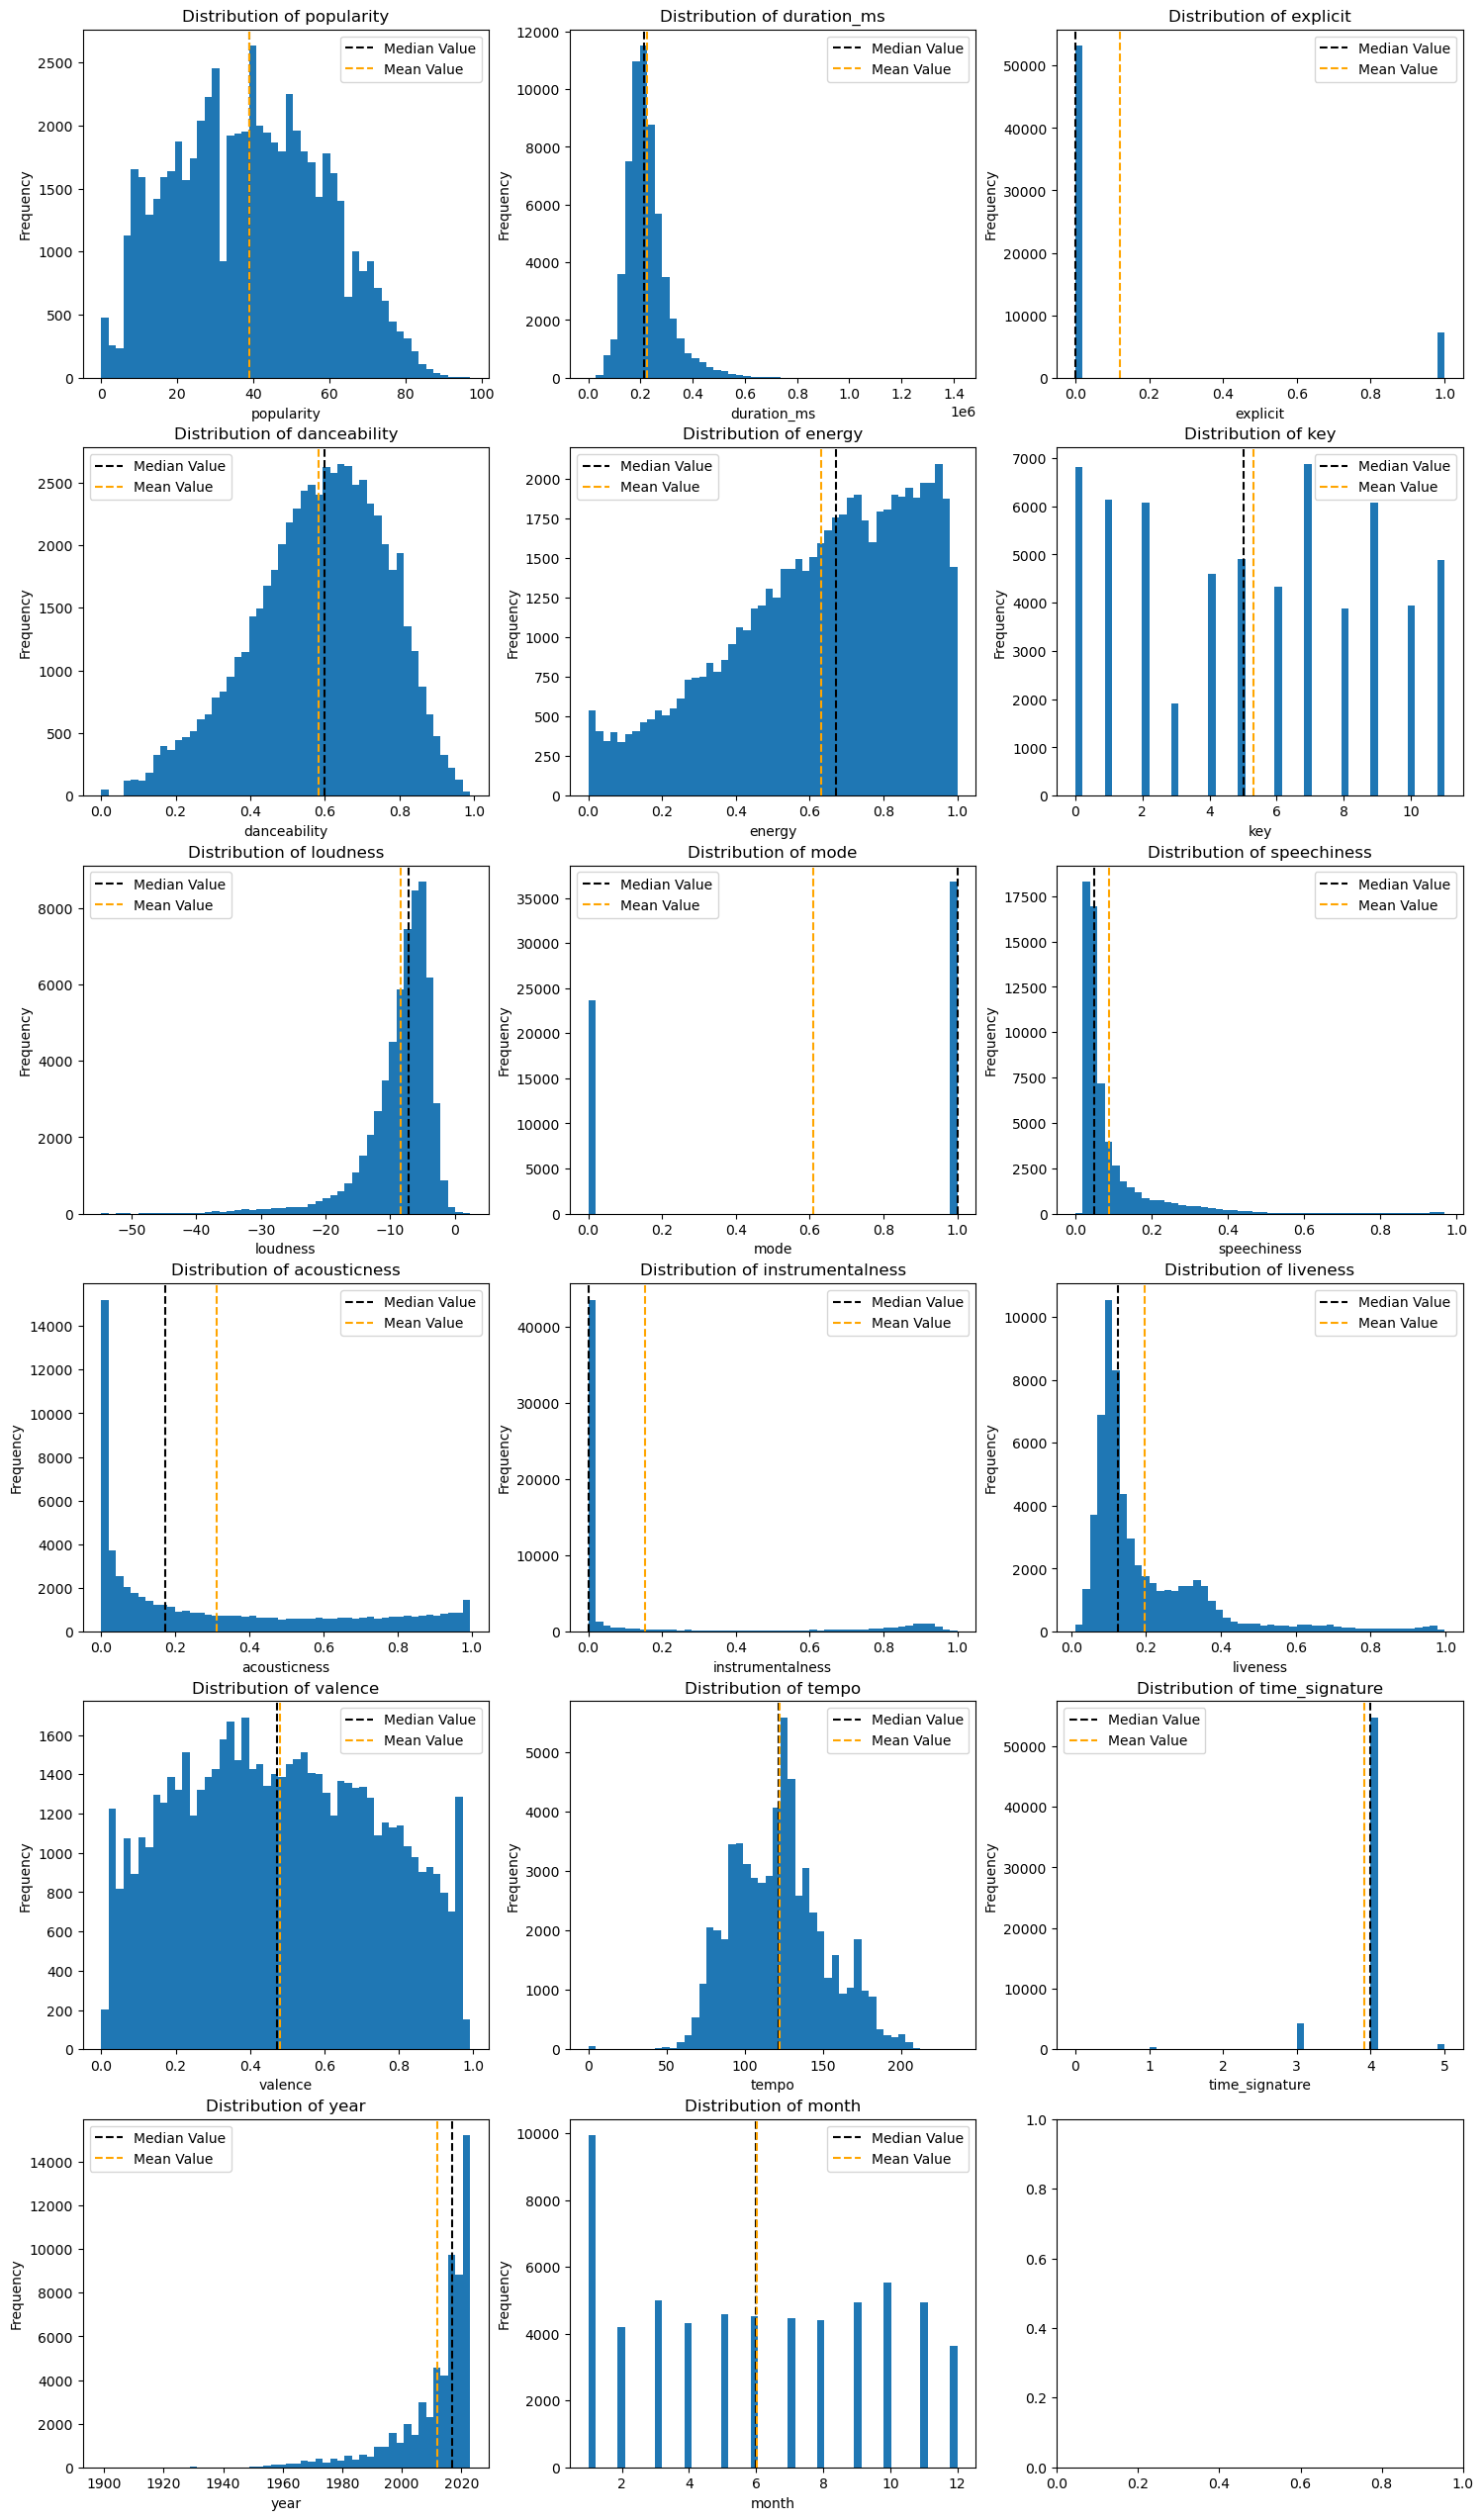

In [20]:
#plotting the disribution of each numeric feature in the form of histograms in subplots
plt.subplots(6,3, figsize=(18,32))

#looping over every feature
for i, column in zip(range(17), df_processing.select_dtypes('number').columns):
    
    plt.subplot(6,3,i+1)
    plt.hist(df_processing[column], bins=50)
    plt.title(f'Distribution of {column}')
    plt.axvline(np.median(df_processing[column]), color='black', linestyle='--', label='Median Value')
    plt.axvline(np.mean(df_processing[column]), color='orange', linestyle='--', label='Mean Value')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()

plt.show()

Straight off the bat we can see some patterns emerge in the histograms of each respective feature. The target variable of this project, `popularity`, shows some normality about a popularity score of 40, but only in a very weak sense.`duration_ms` is heavily centered around 200,000 ms. Approximately 15% of tracks are `explicit`, and there is a pretty even distribution of different `key`s with an outlier key value of 3 being slightly underrepresented. `danceability` shows some normality as well, but seems to be slightly left skewed. `energy` and `loudness` also show some heavy left skewing along their distributions. `mode` seems to be separated with 1/3 of the tracks in a Minor key and 2/3 of the tracks in a Major one. `speechiness`, `acousticness`, and `liveness` all show a very heavy right skew. `instrumentalness` is very centered around 0 with some occurrence of higher values, but nothing significant. `valence` seems somewhat evenly distributed with middle values showing slightly higher frequency, but overall evenly spread. `tempo` seems to have somewhat of a weak normal distribution around 120 BPM, and this is expected as that is the most common tempo for music across all genres. `time_signature` has a clear majority in a single value, with almost 90% of all tracks having a 4/4 time signature, which is also expected as it is the most common time signature across all of music. `year` is heavily left skewed which is expected as the music industry started seeing a huge growth in the 2010's when streaming music became the industry norm for distribution. Lastly, `month` seems to be somewhat evenly distributed across all values except January which has double the frequency.  

### Distribution of Popularity for Each Genre

Now that the overall data's distribution has been analyzed, it's time to do a bit of microanalysis checking the distribution of each genre just to note if any genre is highly concentrated in a only a few popularity brackets. Now when pulling the data from the Spotify API, I tried to pull 100 tracks for each popularity bracket, but not all genres have tracks that exist in each of these brackets. Based on that, we are going to assume that the data pulled is representative of the actual popularity distribution for each genre.

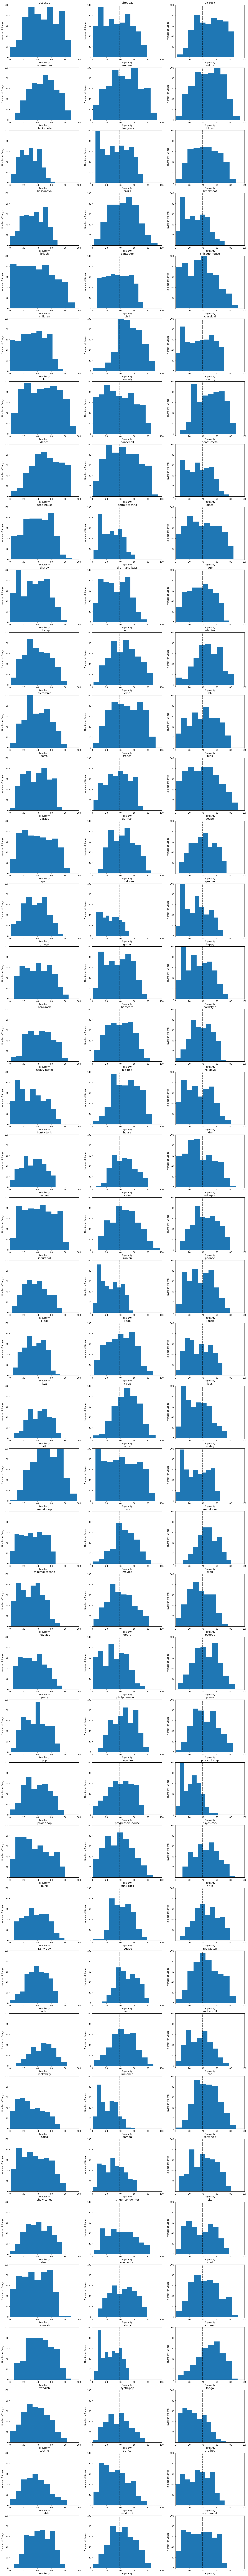

In [21]:
#plotting populairty distribtuion by genre
plt.subplots(41,3,figsize=(20,220))

for x in range(123):
    plt.subplot(41,3,x+1)
    
    #selecting each genre separately
    plt.hist(df_processing[df_processing['track_genre'] == df_processing['track_genre'].unique()[x]]['popularity'], bins=10)
    plt.title(df_processing['track_genre'].unique()[x],fontsize=13)
    plt.axvline(np.median(df_processing['popularity']), linestyle='--', color='black', alpha=0.6)
    plt.xlabel('Popularity')
    plt.ylabel('Number of Songs')
    plt.xlim(0,100)
    plt.ylim(0,100)
    
plt.show()    

From the visualizations a few genres stood out in being overly under-popular in comparison to the median popularity of the entire data set. Black-metal, break-beat, death-metal, detroit-techno, drum-and-base, grindcore, iranian, post-dubstep, romance, and study music all seems to far more unpopular. Even though the sub-genres of metal seem to be unpopular, the core metal genre actually has far more songs that are above average popularity than below. Other notably popular genres are chill, dance and reggae. The rest of the genres have a more even distribution of popular to not popular tracks.

### Representation of Each Genre

Another detail that stood out in those distribution is that some genres seems to have an overall smaller total frequency in comparison to others. It then becomes necessary to check how many tracks of each genre are found in the dataset, and if any genres are greatly overrepresented.

In [22]:
#creating a dataframe of each genre and the number of tracks
genre_counts = df.groupby('track_genre')['track_genre'].count()

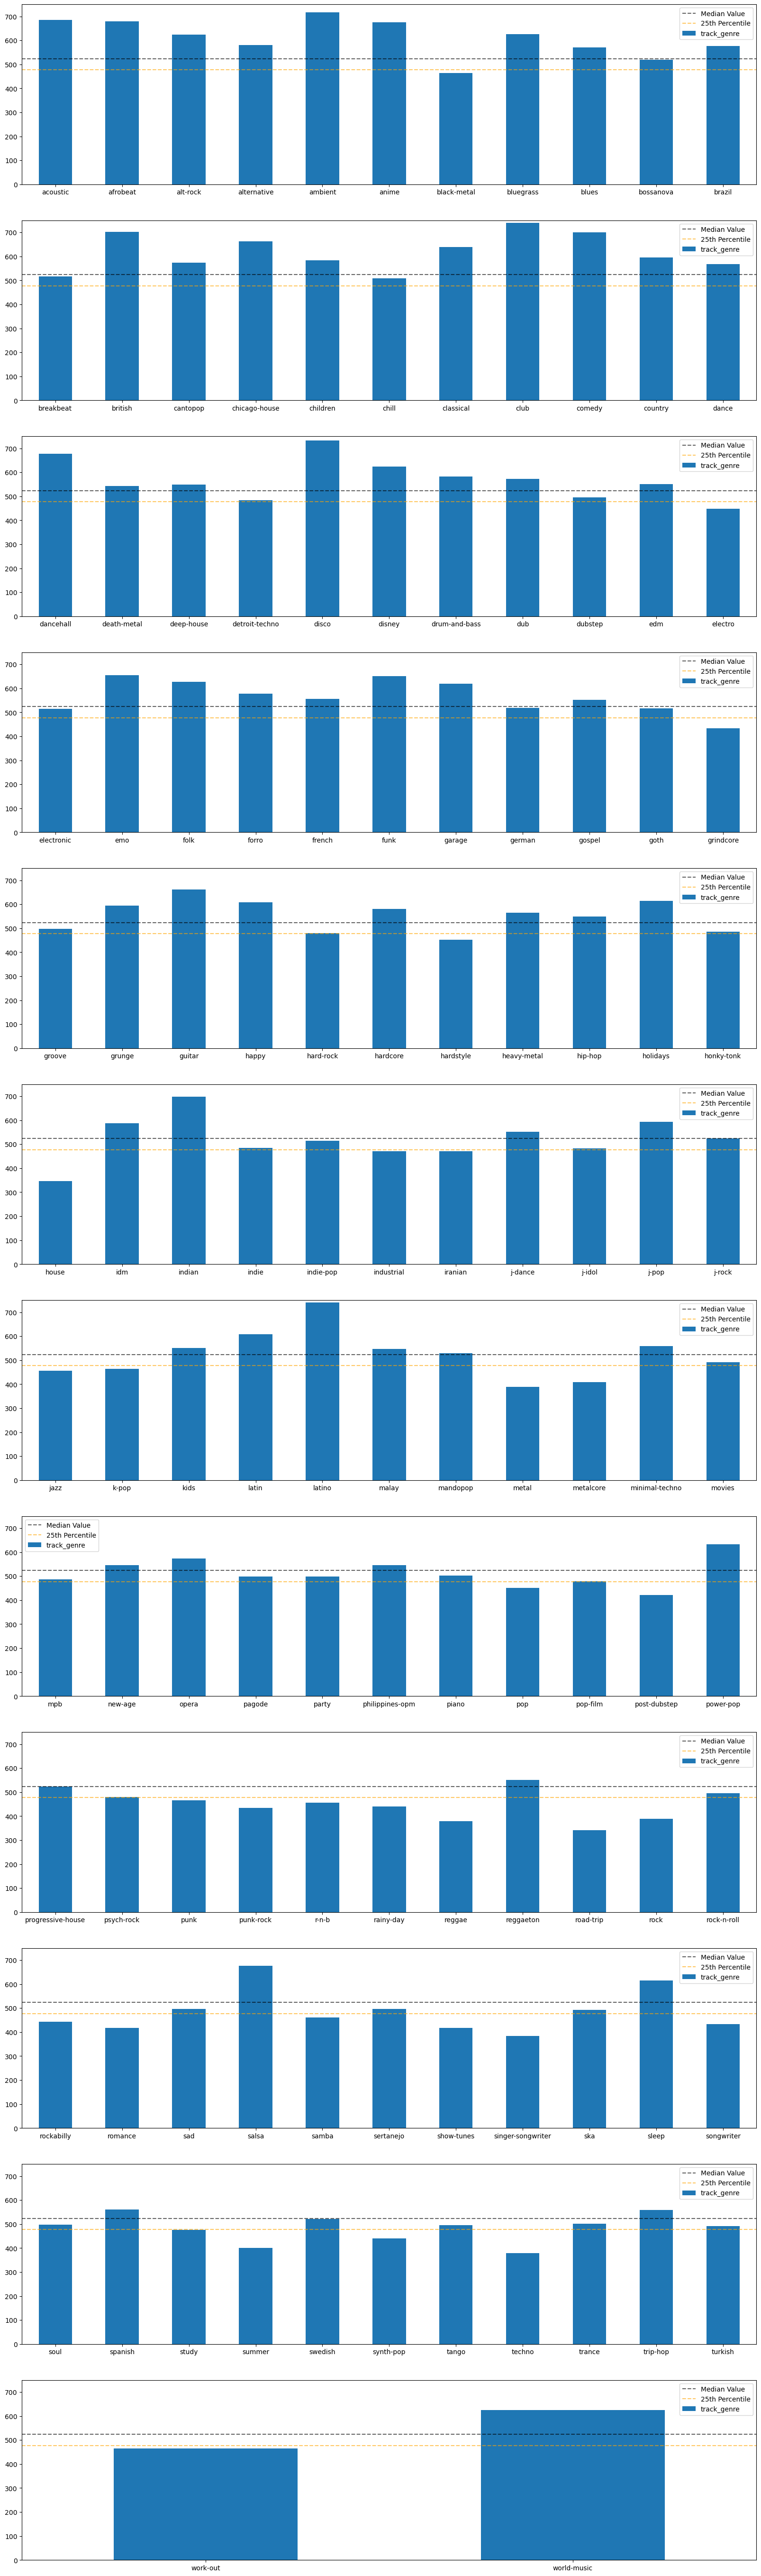

In [23]:
#plotting number of songs per genre
plt.subplots(12,1,figsize=(20,70))
for x in range(12):
    plt.subplot(12,1,x+1)
    if (11*(x+1)) > 123:
        genre_counts.iloc[11*x:].plot(kind='bar')
    else:
        genre_counts.iloc[11*x:11*(x+1)].plot(kind='bar')
    plt.axhline(np.median(genre_counts),linestyle='--', color='black', alpha=0.6, label='Median Value')
    plt.axhline(np.percentile(genre_counts, 25), linestyle='--', color='orange', alpha=0.6, label='25th Percentile')
    plt.xticks(rotation=0)
    plt.xlabel('')
    plt.ylim(0,750)
    plt.legend()
        
plt.show()

In [24]:
pd.DataFrame(genre_counts).describe().T

,count,mean,std,min,25%,50%,75%,max
track_genre,123.0,535.536585,88.999566,341.0,477.5,524.0,590.5,740.0


As was expected, more than a few genres seem to have less representation in respect to the rest of the genres. Some notable ones are metal, reggae, house, and road-trip. The reason these are notable as they had overall higher popularity values, meaning that these genres are underrepresented in number, but they over-represent an overall popularity of that genre.

The least represented genre has 341 tracks, while the median value of tracks per genre is 524. So even though some genres have lower number of tracks, overall there aren't any genres that are completely overlooked.

### Feature Variance for Popular v Not-Popular

Another distribution worth exploring, is the difference in distribution of each genre between popular and not-popular tracks. To do this we need first define that popular is when a `popularity` score is above the median value of that column.

In [25]:
#converting the popularity feature to binary column
df_processing['is_popular'] = np.where(df_processing['popularity'] >= np.median(df_processing['popularity']),
                                       'Popular', 'Not-Popular')

In [26]:
#sanity check
df_processing['is_popular'].value_counts(normalize=True)

Popular        0.504931
Not-Popular    0.495069
Name: is_popular, dtype: float64

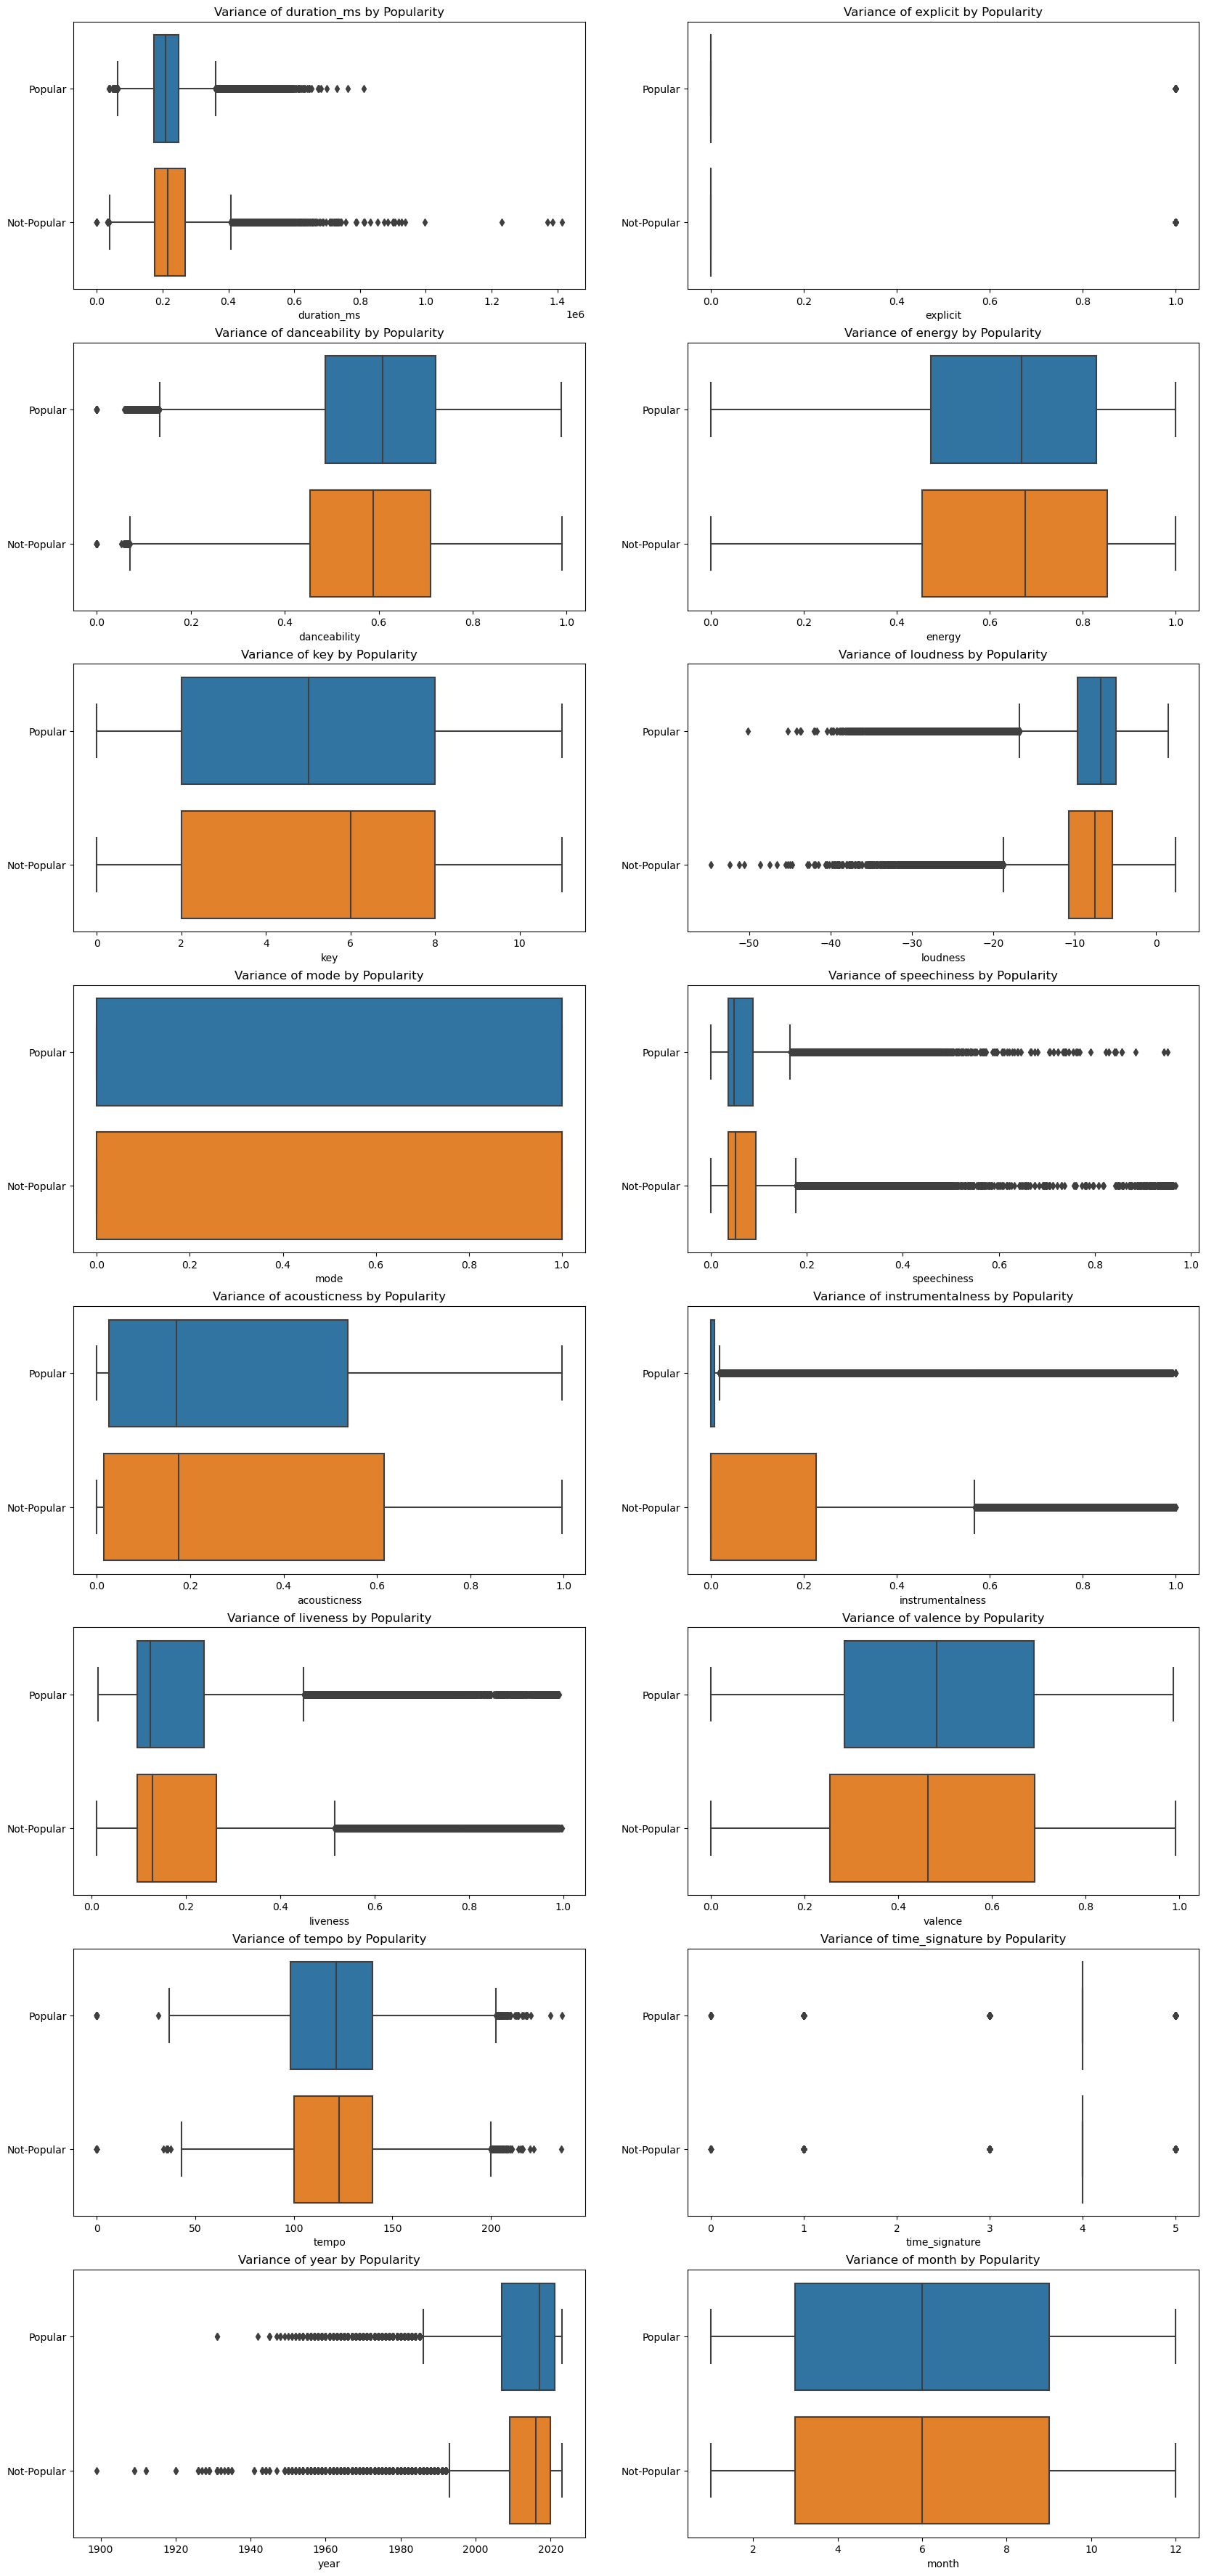

In [27]:
#plotting boxplots to show the difference in variance of popular and not-popular tracks across all features
plt.subplots(8,2, figsize=(20,45))

for i, column in zip(range(16), df_processing.drop(columns=['popularity','is_popular']).select_dtypes('number').columns):
    plt.subplot(8,2,i+1)
    sns.boxplot(data=df_processing, x=column, y='is_popular')
    plt.title(f'Variance of {column} by Popularity')
    plt.ylabel('')

plt.show()    

In general there isn't much of a difference in variance between popular and not-popular tracks across most of the features. The only real difference is that popular tracks have instrumentalness scores of 0 and around 0, while approximately 50% not-popular tracks have an instrumentalness score above 0. Otherwise, their really isn't any significant difference in variance.

In [28]:
#dropping is_popular column as it doesn't serve any use in the rest of the analysis
df_processing.drop(columns='is_popular',inplace=True)

### Feature Correlation

One final avenue for analysis is the exploration of correlation between different features in the dataset.

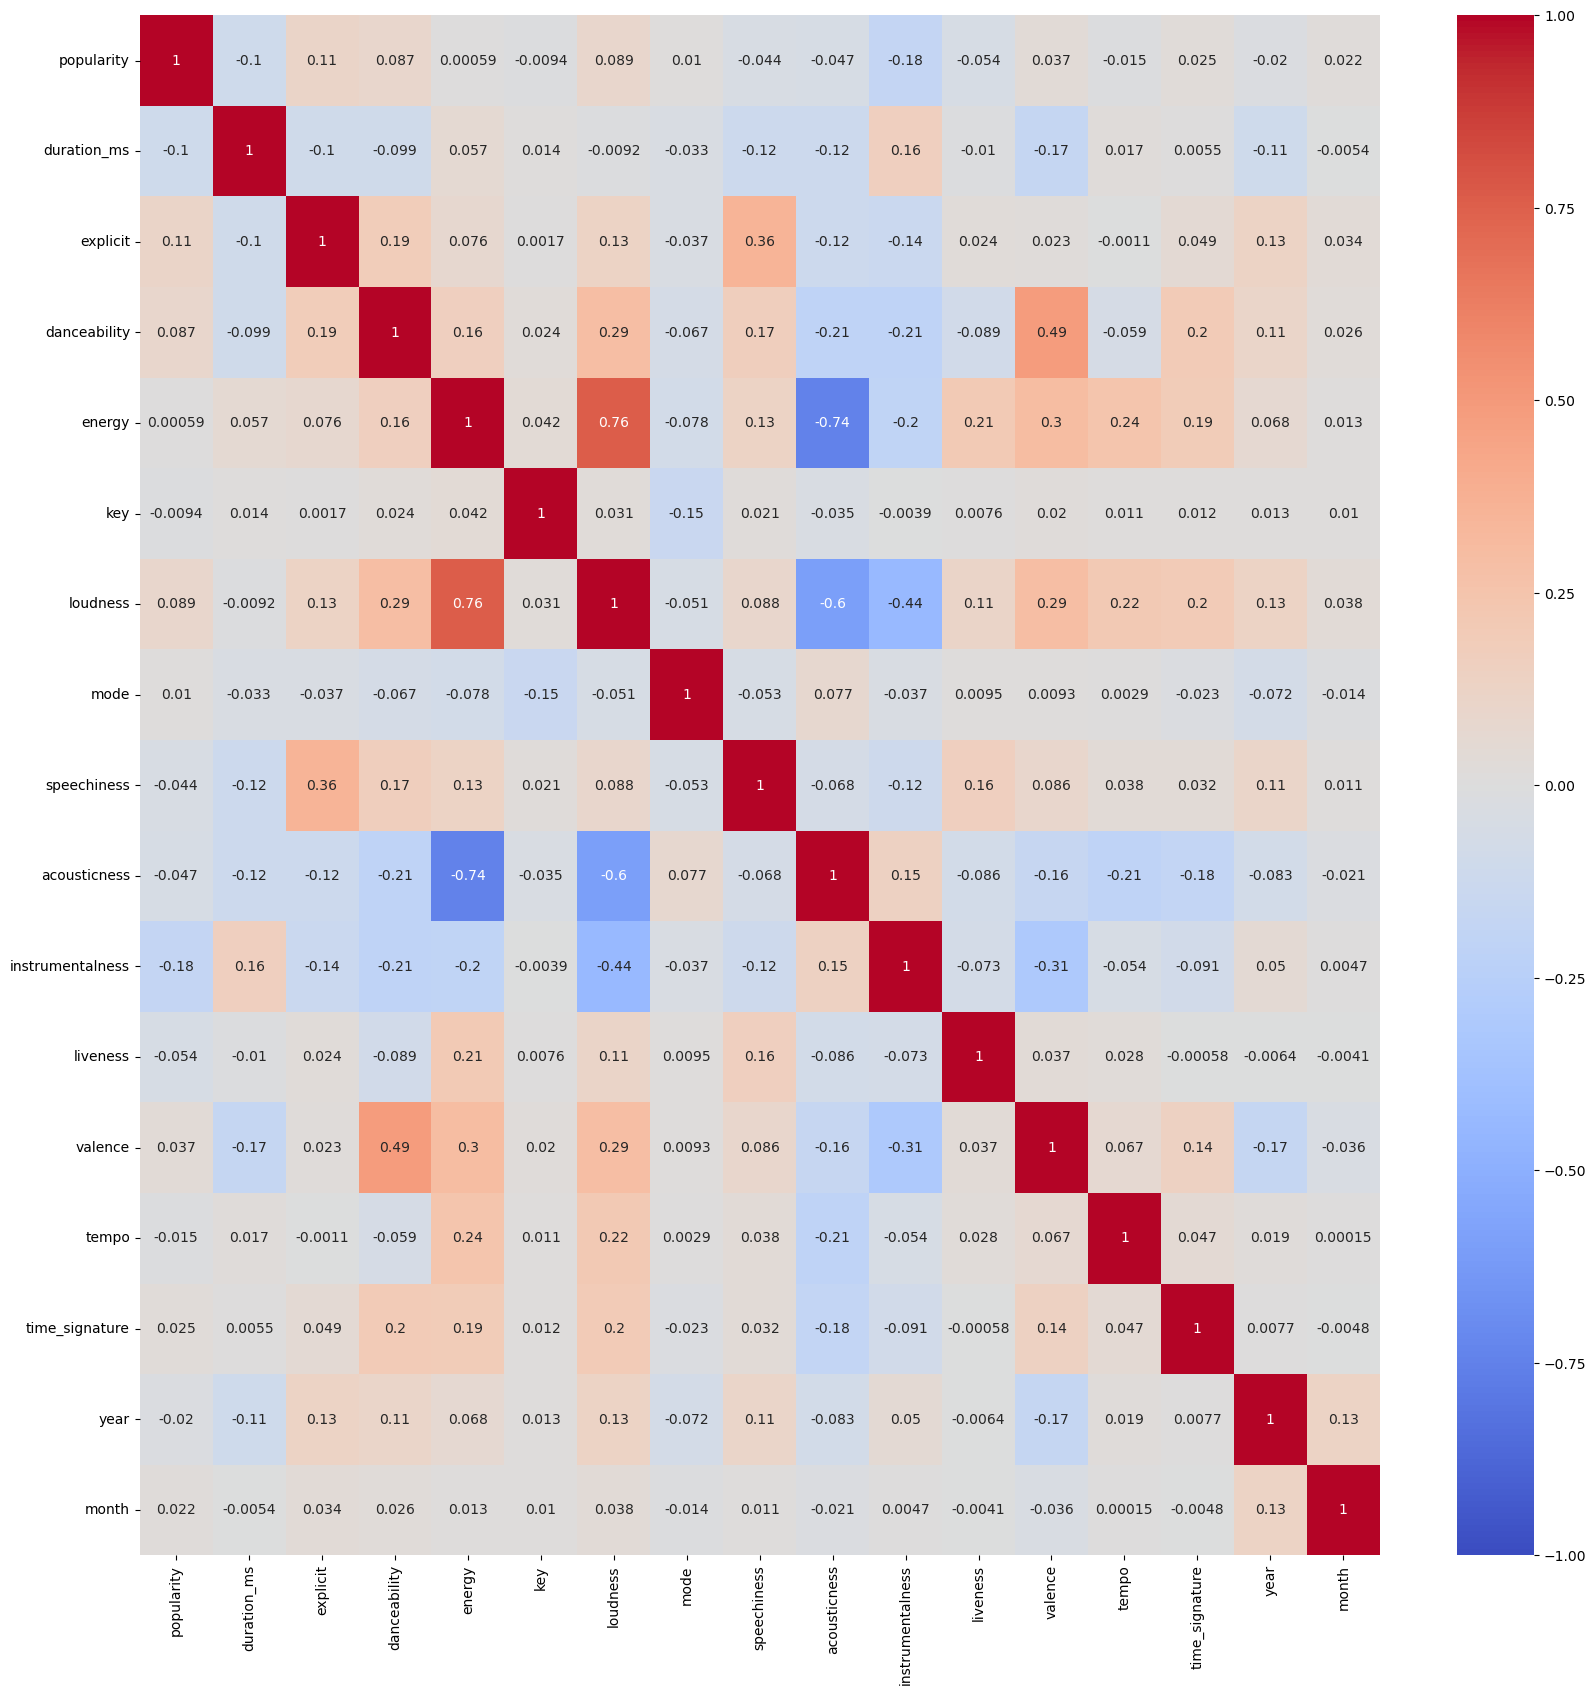

In [29]:
plt.figure(figsize=(20,20))
sns.heatmap(df_processing.corr(), annot=True, vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

The first, and probably most important, observation is that our target variable `popularity` has no significant correlation with any feature at all.

In [30]:
df_processing.corr()['popularity'].sort_values(ascending=False)

popularity          1.000000
explicit            0.111951
loudness            0.088852
danceability        0.086688
valence             0.037326
time_signature      0.024555
month               0.021555
mode                0.010241
energy              0.000585
key                -0.009388
tempo              -0.014895
year               -0.020473
speechiness        -0.044146
acousticness       -0.047312
liveness           -0.053926
duration_ms        -0.104356
instrumentalness   -0.178832
Name: popularity, dtype: float64

The three highest correlations with `popularity` are `instrumentalness` and `duration_ms` with a negative correlation, and `explicit` with a positive one. These correlations are all still insignificant as they are far below 0.5 in absolute value. Every other feature has an absolute value correlation with `popularity` that is below 0.1. This means that linear models might have a difficult time classifying popularity values, but thankfully not all models are linear.

As for the rest of the features, the `energy`, `loudness`, and `acousticness` features seems highly correlated to each other with absolute values greater than 0.6. `instrumentalness` also has a correlations worth noting with `loudness`, but the absolute value is just shy of 0.5. `valence` seems to be correlated with `danceability` (0.49).

From these insights, in order to most effectively follow the assumption of linear models the best features to drop would be `loudness`, `acousticness`, and `instrumentalness`, as they are the feature with highest rate collinearity with other columns, and lowest amount of variation among their respective distributions. As for the case of `valence` and `danceability`, the absolute correlation values is just shy of 0.5, and both features give a great insight to the overall feel of a track. Hopefully neither of them needs to be dropped, but if push comes to shove then the `valence` column should be dropped as the `danceability` feature has higher normality to its values which better fits the assumptions of linear models.

In the case of non-parametric models, which is the majority of machine learning models, no features really need to be dropped as they are unaffected by multicollinearity.

## Final Preprocessing for Modeling

Finally we can finish preprocessing the dataset to make it suitable for modeling. This will include CountVectorizing the `track_genre` column as to make that categorical column into many numeric ones which can be used by the models. Also, we will be setting the threshold for `popularity` classes at the median value of popularity across the data set. We will also be circular encoding the `key` feature in order to simulate the cyclical feature of musical keys. Lastly we will be transforming the `month` feature into a more usable `season` feature by splitting the year up into 4 quarters / seasons.

### Transforming Month to Season

In [31]:
df_final = df_processing.copy()

In [32]:
#transforming month to season
df_final['season'] = np.nan
df_final['season'] = np.where(df_final['month'] < 4, 1, df_final['season']) # January to March
df_final['season'] = np.where((df_final['month'] >= 4) & (df_final['month'] < 7), 2, df_final['season']) #April to June
df_final['season'] = np.where((df_final['month'] >= 7) & (df_final['month'] < 10), 3, df_final['season']) #July to September
df_final['season'] = np.where(df_final['month'] >= 10, 4, df_final['season']) #October to December
df_final['season'] = df_final['season'].astype(int)

In [33]:
#sanity check
df_final['season'].value_counts(normalize=True)

1    0.316444
4    0.233279
3    0.228299
2    0.221978
Name: season, dtype: float64

In [34]:
#dropping month column
df_final.drop(columns='month',inplace=True)

### Circular Encoding key

For those who aren't accustom to music theory, keys obey a cyclical nature just like on a piano. A C note which had a key value of 1, is closer to a B note (11) then it is to a D note (2). For that reason circular encoding this column into two new columns will allow the model to understand and account for this cyclical nature by making use of trigonometric function. 

In [35]:
#Circular encoding the Key column

# Define the circular encoding function
def circular_encode(value, max_value):
    sin_value = np.sin(2 * np.pi * value / max_value)
    cos_value = np.cos(2 * np.pi * value / max_value)
    return sin_value, cos_value

# Apply the function to the key column of your DataFrame
max_value = 11  # maximum value in the key column
df_final[['key_sin', 'key_cos']] = df_final['key'].apply(circular_encode, max_value=max_value).apply(pd.Series)

In [36]:
#dropping the orignal key column
df_final.drop(columns='key',inplace=True)

### CountVectorizing

In [37]:
# creating a custom tokenizer that will only split words based on white space since multi-word genres 
# are formatted with dashes (-) to between the words
def my_tokenizer(text):
    # Split text into tokens based on whitespace characters
    tokens = re.split(r'\s+', text)
    return tokens

In [38]:
#instantiating a CountVectorizer as bagofwords and fitting to the track_genres in df_processing
bagofwords = CountVectorizer(tokenizer=my_tokenizer).fit(df_final['track_genre'])

/Users/ounnuqul/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [39]:
#transforming the track_genre feature into a countvectorized matrix
transformed = bagofwords.transform(df_final['track_genre'])

In [40]:
#formating the matrix into a dataframe
vect_matrix = pd.DataFrame(columns=bagofwords.get_feature_names(), data=transformed.toarray())
vect_matrix.head()

/Users/ounnuqul/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,acoustic,afrobeat,alt-rock,alternative,ambient,anime,black-metal,bluegrass,blues,bossanova,...,summer,swedish,synth-pop,tango,techno,trance,trip-hop,turkish,work-out,world-music
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
#checking that all genres were vectorized
vect_matrix.shape[1] == df_final['track_genre'].nunique()

True

In [42]:
#creating the finalized df by concatenating the df_processing and vect_matrix
df_final = pd.concat([df_final.reset_index(),vect_matrix],axis=1)

In [43]:
#dropping the index column that was created when reseting the index before concatenating
df_final.drop(columns='index', inplace=True)

### Setting Popularity Threshold

In [44]:
#setting the threshold for popularity at the median value
df_final['popularity'] = np.where(df_final['popularity'] >= np.median(df_final['popularity']), 1, 0)

In [45]:
#sanity check
df_final['popularity'].value_counts(normalize=True)

1    0.504931
0    0.495069
Name: popularity, dtype: float64

In [46]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60434 entries, 0 to 60433
Columns: 147 entries, track_id to world-music
dtypes: float64(11), int64(130), object(6)
memory usage: 67.8+ MB


### Saving df_final

In [47]:
#writting to pickle
with open('Data/df_for_modeling.pkl', "wb") as f:
    pickle.dump(df_final, f)

## Conclusion to this Notebook

In this notebook we've gone over the dataset that was pulled straight from the Spotify API. After preprocessing the data into a suitable format, we were able to conduct some in-depth EDA to gain greater insight on the distribution of all the features and how they correlate. We set out some recommendations for which features should be kept in the case of linear modeling. Lastly we finalized the preprocessing of the data preparing it for modeling by countvectorizing genres, circular encoding key, converting month to season, and thresholding popularity. 